<a href="https://colab.research.google.com/github/Sankarsh-Sunku/Implementation-Of-DL-in-Pytorch/blob/main/Metaparams/Predicting_the_residual_sugar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns

<ipython-input-1-64f58cb21691>:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [7]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns (including quality!)
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [17]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,-0.786623
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,0.453492
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,0.453492
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,-0.786623


In [8]:
# convert from pandas dataframe to tensor

# but first drop residual sugar
cols2zscore = cols2zscore.drop('residual sugar')

dataT = torch.tensor( data[cols2zscore].values ).float()
sugar = torch.tensor( data['residual sugar'].values ).float()
sugar = sugar[:,None] # transform to matrix

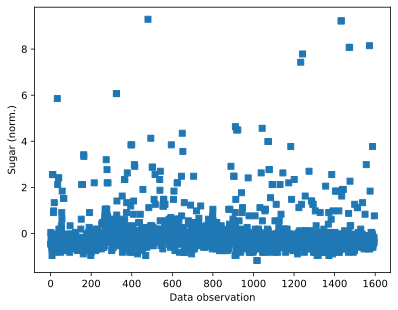

In [9]:
# check values in sugar
plt.plot(sugar,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [10]:
# use scikitlearn to split the data
train_dataSK,test_dataSK, train_labelsSK,test_labelsSK = train_test_split(dataT, sugar, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_dataSK,train_labelsSK)
test_dataDataset  = torch.utils.data.TensorDataset(test_dataSK,test_labelsSK)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [11]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [12]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testLoss[epochi] = lossfun(yHat,y).item()

  # function output
  return trainLoss,testLoss

In [13]:
# create a model and train it
winenet = ANNwine()
trainLoss,testLoss = trainTheModel()

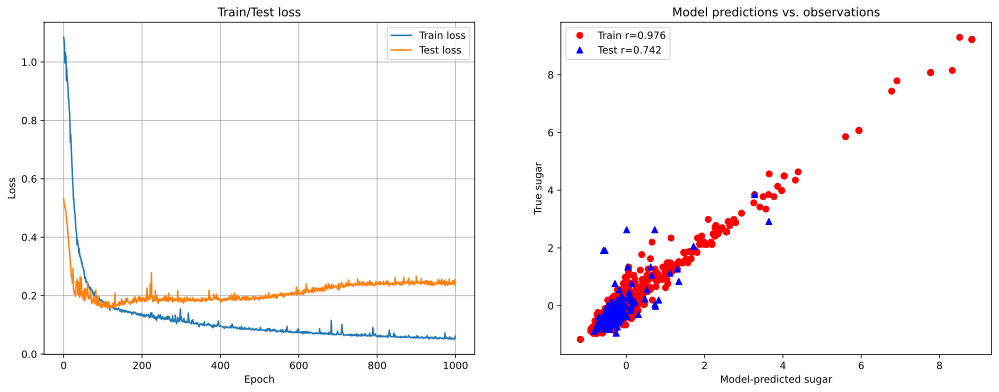

In [14]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = winenet(train_dataSK)
yHatTest  = winenet(test_dataSK)

ax[1].plot(yHatTrain.detach(),train_labelsSK,'ro')
ax[1].plot(yHatTest.detach(),test_labelsSK,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsSK.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelsSK.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

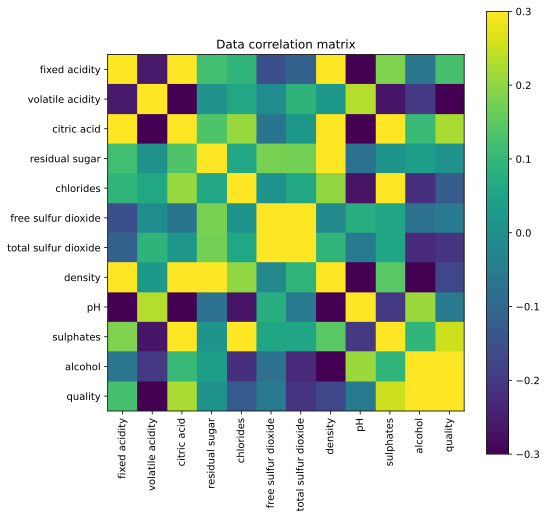

In [15]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()